In [ ]:
from fastai.vision.all import *
from fastai.vision.gan import *
import seaborn as sns
import sys
import torch

In [2]:
run_as_standalone_nb = False

In [3]:
if run_as_standalone_nb:
    root_lib_path = Path('face2anime').resolve()
    if not root_lib_path.exists():
        !git clone https://github.com/davidleonfdez/face2anime.git
    if str(root_lib_path) not in sys.path:
        sys.path.insert(0, str(root_lib_path))
else:
    import local_lib_import

In [4]:
from face2anime.gen_utils import is_iterable
from face2anime.layers import (ConcatPoolHalfDownsamplingOp2d, ConvHalfDownsamplingOp2d,
                               ConvX2UpsamplingOp2d, InterpConvUpsamplingOp2d)
from face2anime.losses import R1GANGPCallback
from face2anime.nb_utils import mount_gdrive
from face2anime.networks import res_critic, res_generator
from face2anime.train_utils import (add_ema_to_gan_learner, custom_load_model,
                                    custom_save_model)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 64
n_channels = 3
bs = 64
save_cycle_len = 5

In [ ]:
# Optional, allows saving parameters in gdrive
# root_gdrive = mount_gdrive()

# Data

## Target ds

animecharacterfaces, by Kaggle user *aadilmalik94*

In [ ]:
# anime_ds_zip_path = Path(root_gdrive)/"ML/animeface-character-dataset.zip"
# !cp "{anime_ds_zip_path}" .
# !unzip animeface-character-dataset.zip >> /.tmpA
# !rm animeface-character-dataset.zip

In [ ]:
anime_ds_path = Path('./animeface-character-dataset/data')
#anime_ds_path = Path('/kaggle/input/animecharacterfaces/animeface-character-dataset/data').resolve()
#target_fns = get_image_files(celeba_path)
# get_image_files is too slow, there's no need to check the extension here
target_fns = anime_ds_path.ls()
target_fns

---

In [ ]:
normalize_tf = Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5]))
normalize_imagenet_tf = Normalize.from_stats(*imagenet_stats)

dblock = DataBlock(blocks=(TransformBlock, ImageBlock),
                   get_x=generate_noise,
                   #get_items=get_image_files,
                   get_items=lambda path: target_fns,
                   splitter=IndexSplitter([]),
                   item_tfms=Resize(img_size, method=ResizeMethod.Crop), 
                   batch_tfms=normalize_tf)
main_path = anime_ds_path
dls = dblock.dataloaders(main_path, path=main_path, bs=bs)

In [ ]:
dls.show_batch()

# Evaluation

In [6]:
base_fid_samples_path = Path('./fid_samples')
n_fid_imgs = 10000

def download_pytorch_fid_calculator():        
    #!git clone https://github.com/mseitzer/pytorch-fid.git
    !pip install pytorch-fid

def create_fid_dirs(base_fid_samples_path):
    base_fid_samples_path.mkdir()
    (base_fid_samples_path/'fake').mkdir()
    (base_fid_samples_path/'real').mkdir()
        
def predict_n(learner, n_imgs, max_bs=64):
    dummy_path = Path('')
    dl = learner.dls.test_dl([dummy_path]*n_imgs, bs=max_bs)   
    inp, imgs_t, _, dec_imgs_t = learner.get_preds(dl=dl, with_input=True, with_decoded=True)
    dec_batch = dls.decode_batch((inp,) + tuplify(dec_imgs_t), max_n=n_imgs)
    return dec_batch
    
def predict_show_n(learner, n_imgs, **predict_n_kwargs):
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    _, axs = plt.subplots(n_imgs, 2, figsize=(6, n_imgs * 3))
    for i, (inp, pred_img) in enumerate(preds_batch):
        inp.show(ax=axs[i][0])
        pred_img.show(ax=axs[i][1])
        
def save_real_imgs(dls, n_imgs=10000, use_input_ds=False):
    n_imgs_left = n_imgs
    while n_imgs_left > 0:
        b = dls.one_batch()
        bs = b[1].size()[0]
        dec_b = dls.decode_batch(b, max_n=bs)
        for i in range(bs):
            if n_imgs_left == 0: break
            tuple_idx = 0 if use_input_ds else 1
            img_t = dec_b[i][tuple_idx]
            img = PILImage.create(img_t)
            img_idx = n_imgs_left-1
            img.save(base_fid_samples_path/f'real/{img_idx}.jpg')
            #if n_imgs_left % 1000 == 0: print("saved " + str(img_idx))
            n_imgs_left -= 1

def save_fake_imgs(learner, n_imgs=10000, **predict_n_kwargs):
    base_path = base_fid_samples_path
    preds_batch = predict_n(learner, n_imgs, **predict_n_kwargs)
    for i, (inp, img) in enumerate(preds_batch):
        PILImage.create(img).save(base_path/f'fake/{i}.jpg')
        
def eval_models(builders, n_epochs, base_path='./models',
                ema=False):
    assert is_iterable(builders) or is_iterable(n_epochs)
    if not is_iterable(builders): 
        builders = [builders] * len(list(n_epochs))
    if not is_iterable(n_epochs): 
        n_epochs = [n_epochs] * len(list(builders))
    for builder, n_ep in zip(builders, n_epochs):
        #model_id = builder.__name__.split('_')[-1]
        learner = builder(for_inference=True)
        custom_load_model(learner, f'noise2anime_{n_ep}ep', with_opt=False,
                          base_path=base_path, with_ema=ema)
        if ema: 
            learner = Learner(learner.dls, learner.ema_model,
                              loss_func=lambda *args: torch.tensor(0.))
        save_fake_imgs(learner, n_imgs=n_fid_imgs)
        print(f'---- after {n_ep} epochs ----')
        !python -m pytorch_fid {base_fid_samples_path/'fake'} {base_fid_samples_path/'real'}

------------------

# Training

In [7]:
class SaveCheckpointsCallback(Callback):
    "Callback that saves the model at the end of each epoch."
    def __init__(self, learn, fn_prefix, base_path=Path('.'), initial_epoch=1,
                 save_cycle_len=1):
        self.fn_prefix = fn_prefix
        self.base_path = base_path
        self.epoch = initial_epoch
        self.save_cycle_len = save_cycle_len
        
    def after_epoch(self):
        if (self.epoch % self.save_cycle_len) == 0:
            fn = f'{self.fn_prefix}_{self.epoch}ep'
            custom_save_model(learn, fn, base_path=self.base_path)
        self.epoch += 1

First, we will train our GAN to:

1. Assess its potential with a small training set (~10k images)
2. Check if the ADA heuristic is applicable. This can be confirmed by looking at the discriminator outputs: after some iterations of training, we should see an increasing divergence in the predictions for real and fake images, leading to a point where the generator doesn't improve and FID gets worse and worse because the discriminator has overfitted to the training set.

Then, if ADA is indeed applicable, we'll try with ADA and adjust its parameters.

## 1. Train without ADA

In [8]:
class LossWrapper():
    def __init__(self, orig_loss, loss_args_interceptors=None):
        self.orig_loss = orig_loss
        self.loss_args_interceptors = loss_args_interceptors or []

    def __call__(self, *args, **kwargs):
        for interceptor in self.loss_args_interceptors:
            interceptor(*args, **kwargs)
        return self.orig_loss(*args, **kwargs)


class CritPredsTracker:
    def __init__(self):
        self.real_pred_batch_means = []
        self.fake_pred_batch_means = []

    def __call__(self, real_pred, fake_pred):
        self.real_pred_batch_means.append(real_pred.mean().item())
        self.fake_pred_batch_means.append(fake_pred.mean().item())
        
    def load_from_df(self, df):
        self.real_pred_batch_means = df['RealPredsBatchMean'].to_list()
        self.fake_pred_batch_means = df['FakePredsBatchMean'].to_list()
        
    def to_df(self):
        return pd.DataFrame(dict(RealPredsBatchMean=c_preds_tracker.real_pred_batch_means,
                                 FakePredsBatchMean=c_preds_tracker.fake_pred_batch_means))


def save_preds(c_preds_tracker, filepath):
    return c_preds_tracker.to_df().to_csv(filepath)


class LossStore(Callback):
    def __init__(self):
        self.g_losses = []
        self.c_losses = []

    def after_epoch(self):
        #if not self.training: return        
        # self.training is already false here even when training.
        # An alternative is to disable cb when not needed:
        #      `with learn.removed_cbs(...): ...`
        self.g_losses.append(self.gan_trainer.gen_loss.value.item())
        self.c_losses.append(self.gan_trainer.crit_loss.value.item())    


def create_learner(for_inference=False, gp_w=1., c_loss_interceptors=None):
    leakyReLU02 = partial(nn.LeakyReLU, negative_slope=0.2)
    down_op = ConvHalfDownsamplingOp2d(ks=4, act_cls=leakyReLU02, bn_1st=False,
                                       norm_type=NormType.Batch)
    id_down_op = ConcatPoolHalfDownsamplingOp2d(conv_ks=3, act_cls=None, norm_type=None)
    critic = res_critic(img_size, n_channels, down_op, id_down_op,
                        n_extra_convs_by_res_block=0, act_cls=leakyReLU02,
                        bn_1st=False, n_features=128, flatten_full=True)
    up_op = ConvX2UpsamplingOp2d(ks=4, act_cls=nn.ReLU, bn_1st=False)
    id_up_op = InterpConvUpsamplingOp2d(ks=3, act_cls=None)
    generator = res_generator(img_size, n_channels, up_op, id_up_op, bn_1st=False, 
                              n_features=128)
    
    cbs = []
    if not for_inference:
        cbs.append(R1GANGPCallback(weight=gp_w))
    def gen_loss_func(*args): return 0
    crit_loss_func = nn.BCEWithLogitsLoss()
    loss_G, loss_C = gan_loss_from_func(gen_loss_func, crit_loss_func)
    loss_C = LossWrapper(loss_C, c_loss_interceptors)
    
    learn = GANLearner(dls, generator, critic, loss_G, loss_C,
                       opt_func=partial(Adam, mom=0., sqr_mom=0.99, wd=0.),
                       cbs=cbs, switcher=FixedGANSwitcher(n_crit=1, n_gen=1),
                       switch_eval=False)
    learn.recorder.train_metrics=True
    learn.recorder.valid_metrics=False
    add_ema_to_gan_learner(learn, dblock, main_path, decay=0.999)
    return learn

In [ ]:
c_preds_tracker = CritPredsTracker()
learn = create_learner(c_loss_interceptors=[c_preds_tracker])
learn.add_cb(SaveCheckpointsCallback(learn, 'noise2anime', initial_epoch=100,
                                     save_cycle_len=save_cycle_len))
learn.add_cb(LossStore())
ema_g_learn = Learner(dls, learn.ema_model, loss_func=lambda *args: torch.tensor(0.))
lr = 2e-4
# learn.model.generator, learn.model.critic

In [ ]:
# custom_load_model(learn, 'noise2anime_200ep', base_path='../input/noise2anime-weights/', with_ema=True)
# preds_df = pd.read_csv(io.StringIO(preds_csv_str), index_col=0)
# c_preds_tracker.load_from_df(preds_df)
# with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
#     displayable_learn.show_results(ds_idx=0)

In [ ]:
lr = 2e-4
learn.fit(200, lr)
with learn.removed_cbs([learn.save_checkpoints, learn.loss_store]) as displayable_learn:
    displayable_learn.show_results(ds_idx=0)

In [ ]:
ema_g_learn.show_results(ds_idx=0)

In [ ]:
save_preds(c_preds_tracker, Path('face2anime_crit_preds_200ep.csv'))

Text(0, 0.5, 'Critic preds')

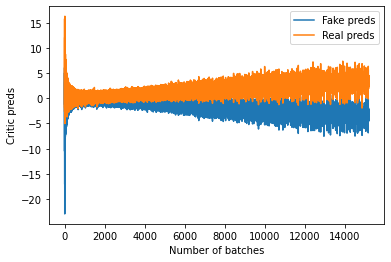

In [12]:
preds_xs = range(len(c_preds_tracker.real_pred_batch_means))
sns.lineplot(x=preds_xs, y=c_preds_tracker.fake_pred_batch_means, label='Fake preds')
ax=sns.lineplot(x=preds_xs, y=c_preds_tracker.real_pred_batch_means, label='Real preds')
ax.set_xlabel('Number of batches')
ax.set_ylabel('Critic preds')

Text(0, 0.5, 'Critic preds')

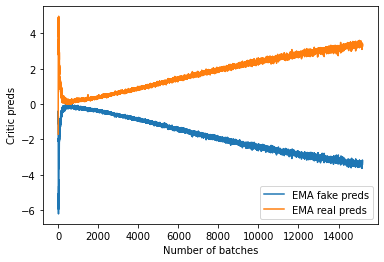

In [13]:
smooth_real_preds = list(c_preds_tracker.real_pred_batch_means)
smooth_fake_preds = list(c_preds_tracker.fake_pred_batch_means)
for i in range(1, len(smooth_real_preds)):
    smooth_real_preds[i] = smooth_real_preds[i-1] * 0.9 + smooth_real_preds[i] * 0.1
    smooth_fake_preds[i] = smooth_fake_preds[i-1] * 0.9 + smooth_fake_preds[i] * 0.1
sns.lineplot(x=preds_xs, y=smooth_fake_preds, label='EMA fake preds')    
ax=sns.lineplot(x=preds_xs, y=smooth_real_preds, label='EMA real preds')
ax.set_xlabel('Number of batches')
ax.set_ylabel('Critic preds')

The following FID values have been obtained after executing code of appendix A:

In [14]:
epochs = list(range(5, 201, 5))
all_fids_no_ema = ([226.9, 169.4, 96.9, 84.9, 75.3, 62.3, 54.5, 43.2, 48.4, 42.2, 40.3, 35.9, 36.3, 31.0, 32.7, 37.9, 29.3, 32.7, 28.4, 30.9] 
                   + [28.8, 23.4, 30.6, 31.7, 34.9, 29.2, 28.6, 28.5, 31.5, 30.9, 28.0, 25.4, 27.9, 28.0, 34.9, 24.2, 26.8, 27.4, 28.3, 30.4])
# 201-230 no ema with lr=5e-5: [25.0, 22.4, 23.9, 24.6, 23.7, 23.2]
all_fids_ema = ([313.2, 342.7, 307.4, 279.9, 119.5, 88.2, 58.9, 50.5, 45.0, 40.7, 32.1, 31.2, 29.3, 27.8, 26.7, 26.1, 25.4, 24.5, 23.8, 22.9] 
                + [20.9, 20.7, 20.6, 20.2, 20.2, 20.1, 20.0, 20.0, 19.2, 19.7, 20.2, 20.3, 19.5, 19.6, 19.8, 19.8, 20.0, 20.3, 20.8, 20.6])
# 201-230 with ema and lr=5e-5: [19.8, 20.4, 20.7, 21.0, 21.6, 21.1]

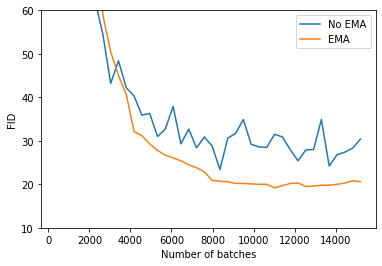

In [16]:
start_ep = 0
end_ep = min(len(all_fids_no_ema), len(all_fids_ema))
losscmp_xs = range(start_ep, end_ep)
# Divide by 2 because we only track preds when training critic
n_crit_batches_by_epoch = math.ceil(len(dls.dataset) / bs) // 2
xs_batches = [ep * n_crit_batches_by_epoch for ep in epochs]
sns.lineplot(x=xs_batches, y=all_fids_no_ema[start_ep:end_ep], label='No EMA')
ax=sns.lineplot(x=xs_batches, y=all_fids_ema[start_ep:end_ep], label='EMA')
ax.set_xlabel('Number of batches')
ax.set_ylabel('FID')
ax.set_ybound(10, 60)
# #plt.legend(title='...')

We can see that FID stops going down after approximately half of training, which is the point when the overlap between the distributions of real and fake preds is becoming minimal, about less than 10%.

In [ ]:
loss_xs = range(len(learn.loss_store.c_losses))
sns.lineplot(x=loss_xs, y=learn.loss_store.c_losses, label='C loss')
ax=sns.lineplot(x=loss_xs, y=learn.loss_store.g_losses, label='G loss')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss')

---

In [ ]:
from IPython.display import FileLink
FileLink('./models/noise2anime_200ep.pth')

In [ ]:
FileLink('./models/noise2anime_200ep_ema.pth')

In [ ]:
FileLink('face2anime_crit_preds_200ep.csv')

# Appendix A: performing evaluation

In [ ]:
download_pytorch_fid_calculator()
create_fid_dirs(base_fid_samples_path)

In [ ]:
save_real_imgs(dls, n_fid_imgs)

In [ ]:
eval_models(create_learner, list(range(5, 201, 5)), base_path='./models')

In [ ]:
eval_models(create_learner, list(range(5, 201, 5)), base_path='./models', ema=True)

Show sample fake image:

In [ ]:
PILImage.create(base_fid_samples_path/'fake/9.jpg')